## Import Necessary Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


%matplotlib inline


## Imports Datasets from Kaggle

In [2]:
from typing import Optional

from transformers.models.esm.openfold_utils.protein import from_prediction
!pip install kagglehub

/Users/simon/PycharmProjects/rec-sys-project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset Loading 
#### Normally datasets are downloaded from the Kaggle, but in the purpose of time-saving the local path placed instead.
#### If you want to download the datasets again, just uncomment the code below.

In [3]:
import kagglehub

# path = "/Users/masoud/Downloads/Netflix/orginal_file"

path = kagglehub.dataset_download("netflix-inc/netflix-prize-data")

print("Path to dataset files:", path)

Resuming download from 101711872 bytes (614481942 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/netflix-inc/netflix-prize-data?dataset_version_number=2 (101711872/716193814) bytes left.


100%|██████████| 683M/683M [00:53<00:00, 11.4MB/s] 

Extracting files...


Path to dataset files: /Users/simon/.cache/kagglehub/datasets/netflix-inc/netflix-prize-data/versions/2


## Loading and preprocessing Netflix Dataset

In [4]:
# File paths for all four datasets
file_paths = [
    f"{path}/combined_data_1.txt",
    f"{path}/combined_data_2.txt",
    f"{path}/combined_data_3.txt",
    f"{path}/combined_data_4.txt"
]

# Helper function to parse the Netflix file
def parse_netflix_file(lines):
    parsed_rows = []
    movie_id = None

    for line in lines:
        line = line.strip()
        if line.endswith(":"):
            movie_id = int(line[:-1])  # Remove colon
        else:
            user_id, rating, date = line.split(",")
            parsed_rows.append([movie_id, int(user_id), int(rating), date])

    df = pd.DataFrame(parsed_rows, columns=["MovieID", "UserID", "Rating", "Date"])
    df["Date"] = pd.to_datetime(df["Date"])
    return df

# Parse all four files and combine into one DataFrame
dataframes = []

for file_path in file_paths:
    with open(file_path, 'r') as f:
        df = parse_netflix_file(f.readlines())
        dataframes.append(df)

# Combine all DataFrames into one
combined_data = pd.concat(dataframes, ignore_index=True)

# Show preview
print("Combined data preview:")
print(combined_data.head())


Combined data preview:
   MovieID   UserID  Rating       Date
0        1  1488844       3 2005-09-06
1        1   822109       5 2005-05-13
2        1   885013       4 2005-10-19
3        1    30878       4 2005-12-26
4        1   823519       3 2004-05-03


## Convert Date Column to Datetime

In [5]:
# Convert date to datetime
combined_data['Date'] = pd.to_datetime(combined_data['Date'])

In [6]:
combined_data

,MovieID,UserID,Rating,Date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03
...,...,...,...,...
100480502,17770,1790158,4,2005-11-01
100480503,17770,1608708,3,2005-07-19
100480504,17770,234275,1,2004-08-07
100480505,17770,255278,4,2004-05-28


## Unique Values in the Ratings Dataset

In [7]:
combined_data.nunique()

MovieID     17770
UserID     480189
Rating          5
Date         2182
dtype: int64

##  Save Dataset to Parquet Format

In [8]:
# Save to Parquet
output_parquet = "./netflix.parquet" 
combined_data.to_parquet(output_parquet, index=False)

In [9]:
combined_data = pd.read_parquet('netflix.parquet')


In [10]:
# Check structure
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100480507 entries, 0 to 100480506
Data columns (total 4 columns):
 #   Column   Dtype         
---  ------   -----         
 0   MovieID  int64         
 1   UserID   int64         
 2   Rating   int64         
 3   Date     datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 3.0 GB


In [11]:
combined_data.describe()

,MovieID,UserID,Rating,Date
count,1.004805e+08,1.004805e+08,1.004805e+08,100480507
mean,9.070915e+03,1.322489e+06,3.604290e+00,2004-10-08 18:52:22.325617920
min,1.000000e+00,6.000000e+00,1.000000e+00,1999-11-11 00:00:00
25%,4.677000e+03,6.611980e+05,3.000000e+00,2004-04-30 00:00:00
50%,9.051000e+03,1.319012e+06,4.000000e+00,2005-01-21 00:00:00
75%,1.363500e+04,1.984455e+06,4.000000e+00,2005-07-08 00:00:00
max,1.777000e+04,2.649429e+06,5.000000e+00,2005-12-31 00:00:00
std,5.131891e+03,7.645368e+05,1.085219e+00,NaN


## hecking for Missing Values

In [12]:
combined_data.isnull().sum()

MovieID    0
UserID     0
Rating     0
Date       0
dtype: int64

## Checking for Duplicate Rows

In [13]:
# check duplicates
combined_data.duplicated().sum()

0

## Rating Distribution
### We create a bar chart to examine how user ratings are distributed in the dataset.

<Axes: title={'center': 'Rating Distribution'}, xlabel='Rating'>

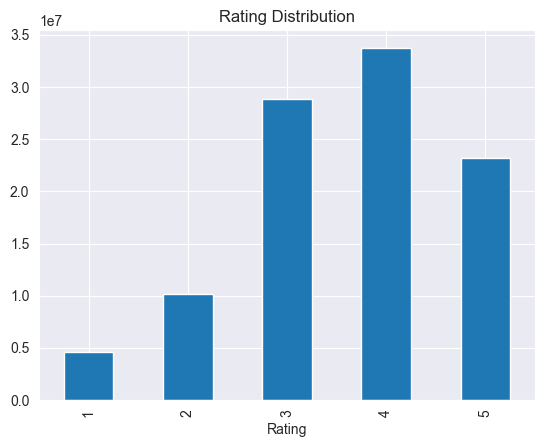

In [14]:
combined_data['Rating'].value_counts().sort_index().plot(kind='bar', title='Rating Distribution')

### Average Rating Over Time

/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_13228/1706693649.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  combined_data.set_index('Date').resample('M')['Rating'].mean().plot(title='Average Rating Over Time')


<Axes: title={'center': 'Average Rating Over Time'}, xlabel='Date'>

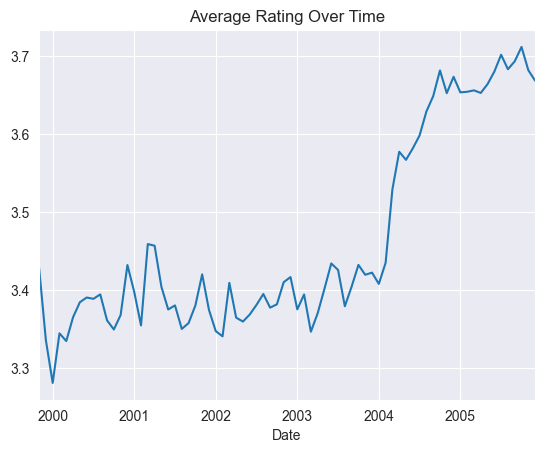

In [15]:
combined_data.set_index('Date').resample('M')['Rating'].mean().plot(title='Average Rating Over Time')

In [16]:
# Rename all columns
combined_data = combined_data.rename(columns={
    'UserID': 'user_id',
    'MovieID': 'movie_id',
    'Rating': 'Rating',
    'Date': 'Date'
})


## Filtering Users for a Comparable and Fair Model

### In our work with the **Netflix dataset**, we deliberately sample only users who have provided **more than 20 ratings**.

### This decision was made to ensure consistency and fairness in our recommendation model — and it's inspired by the design of the **MovieLens dataset**, which includes **only users with more than 20 ratings** by default.


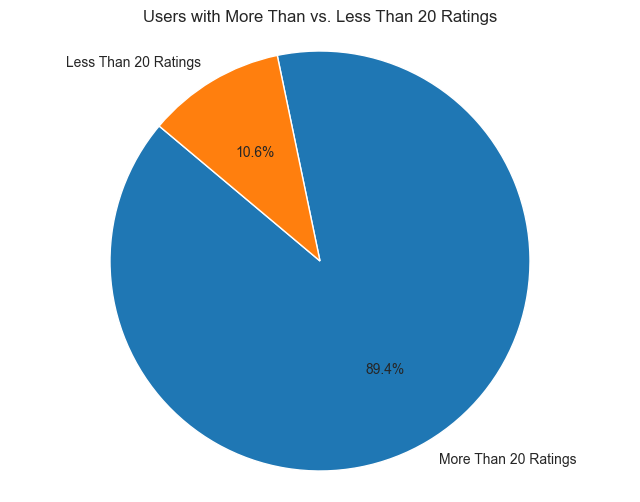

In [17]:
# Step 1: Count ratings per user
user_rating_counts = combined_data.groupby('user_id').size()

# Step 2: Split users
users_more_than_20 = user_rating_counts[user_rating_counts > 20]
users_less_than_20 = user_rating_counts[user_rating_counts < 20]

# Step 3: Calculate percentages
total_considered = len(users_more_than_20) + len(users_less_than_20)
percent_more = (len(users_more_than_20) / total_considered) * 100
percent_less = (len(users_less_than_20) / total_considered) * 100

# Step 4: Pie chart
labels = ['More Than 20 Ratings', 'Less Than 20 Ratings']
sizes = [percent_more, percent_less]

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%.1f%%', startangle=140)
plt.title('Users with More Than vs. Less Than 20 Ratings')
plt.axis('equal')
plt.show()

# Step 5: Create new DataFrame for users with >20 ratings
active_users_df = combined_data[combined_data['user_id'].isin(users_more_than_20.index)]

# Stratified Sampling & Temporal Validation of Netflix Ratings

## We perform a 10% stratified sample from the full Netflix ratings dataset and validate the representativeness of the sample across:

### Rating values

### User activity

### Movie popularity

### Temporal trends (monthly rating volume and composition)

## Step 1: Stratified Sampling (1% by Rating)


In [18]:
# Step 1: Your original rating-based sampling
sample_frac = 0.01
sampled_df = active_users_df.groupby('Rating', group_keys=False).apply(
    lambda x: x.sample(frac=sample_frac, random_state=42)
).reset_index(drop=True)

# Step 2: Now take 10% of the users from this sampled dataes
unique_users = sampled_df['user_id'].unique()
sampled_users = pd.Series(unique_users).sample(frac=sample_frac, random_state=42)

# Filter the dataframe to only include those users
final_sampled_df = sampled_df[sampled_df['user_id'].isin(sampled_users)]

/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_13228/1190908213.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = active_users_df.groupby('Rating', group_keys=False).apply(


## Step 2: Define Comparison Function for Bar Charts


In [19]:
def compare_distributions(original_df, final_sampled_df, column, top_n=None, title_suffix=""):
    orig_counts = original_df[column].value_counts()
    samp_counts = final_sampled_df[column].value_counts()

    orig_pct = orig_counts / len(original_df) * 100
    samp_pct = samp_counts / len(final_sampled_df) * 100

    if top_n:
        top_items = orig_counts.head(top_n).index
        orig_counts = orig_counts.loc[top_items]
        samp_counts = samp_counts.loc[top_items]
        orig_pct = orig_pct.loc[top_items]
        samp_pct = samp_pct.loc[top_items]

    df_compare = pd.DataFrame({
        'Original Count': orig_counts,
        'Sample Count': samp_counts,
        'Original %': orig_pct,
        'Sample %': samp_pct
    }).fillna(0).sort_index()

    # Count comparison
    ax = df_compare[['Original Count', 'Sample Count']].plot(
        kind='bar', figsize=(10, 5), title=f"{column} - Count Comparison {title_suffix}", grid=True
    )
    ax.set_ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Percentage comparison
    ax = df_compare[['Original %', 'Sample %']].plot(
        kind='bar', figsize=(10, 5), title=f"{column} - Percentage Comparison {title_suffix}", grid=True
    )
    ax.set_ylabel("Percentage (%)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## Step 3: Compare Distributions (Rating, User, Movie, Month)

/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_13228/1567275843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_users_df['YearMonth'] = active_users_df['Date'].dt.to_period('M').astype(str)
/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_13228/1567275843.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_sampled_df['YearMonth'] = final_sampled_df['Date'].dt.to_period('M').astype(str)


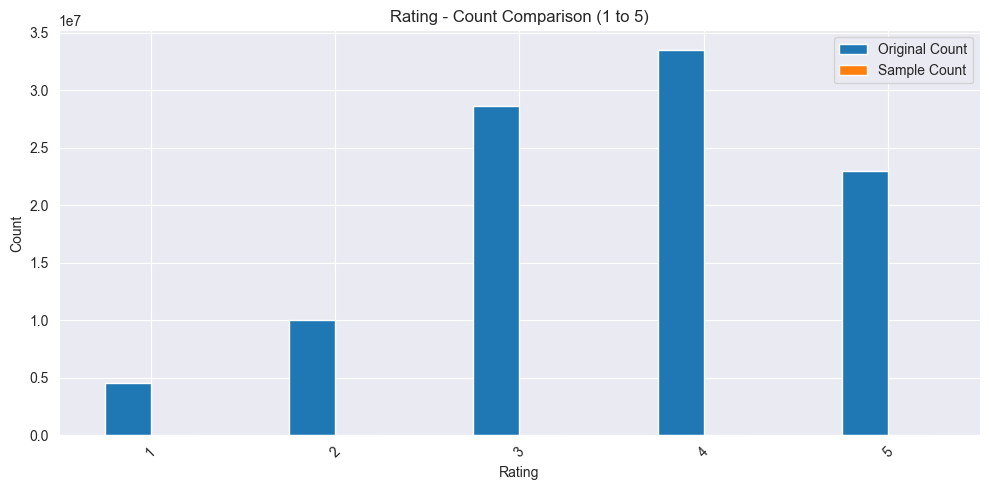

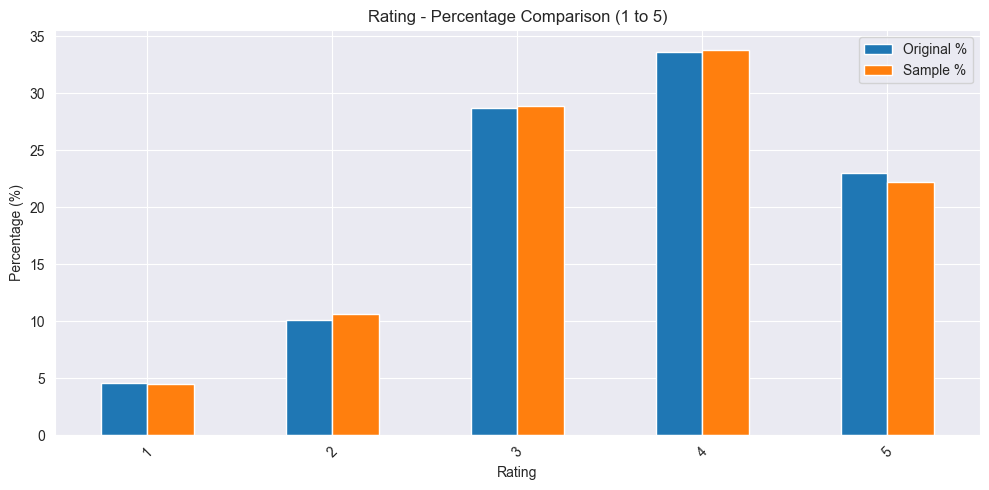

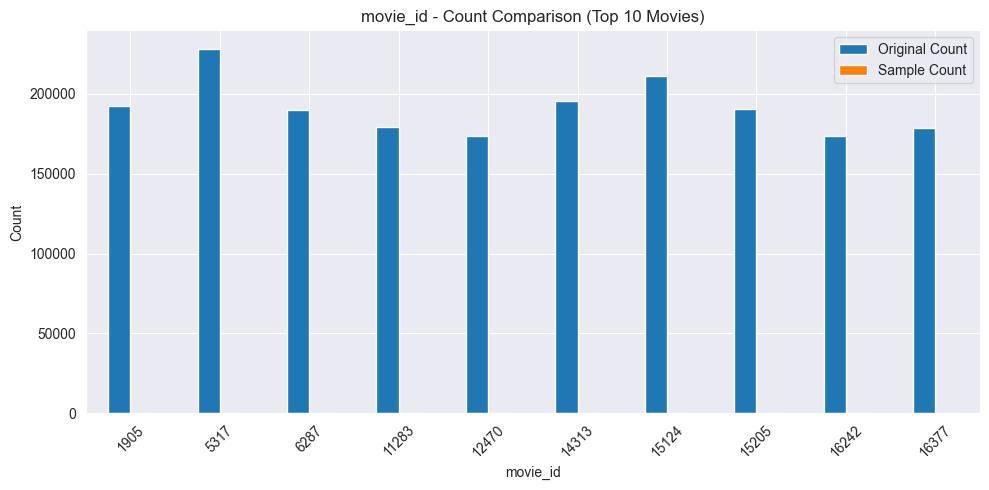

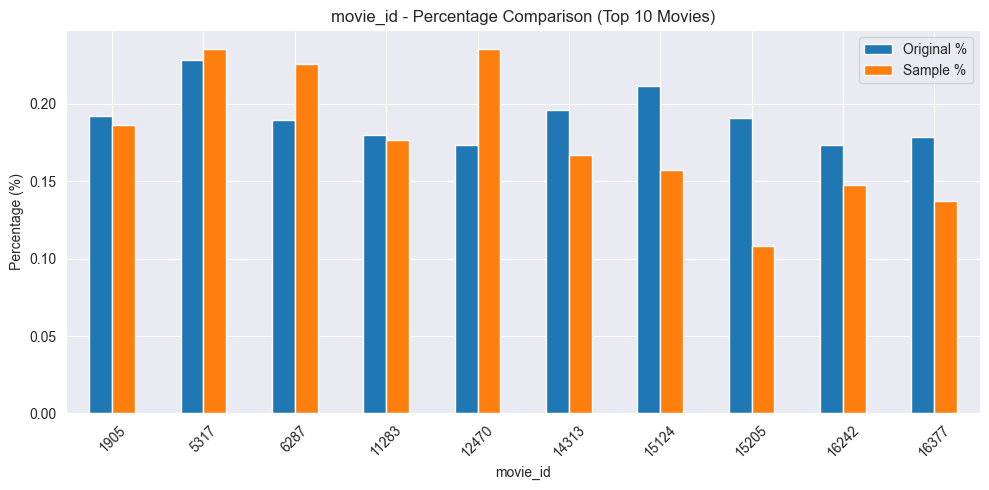

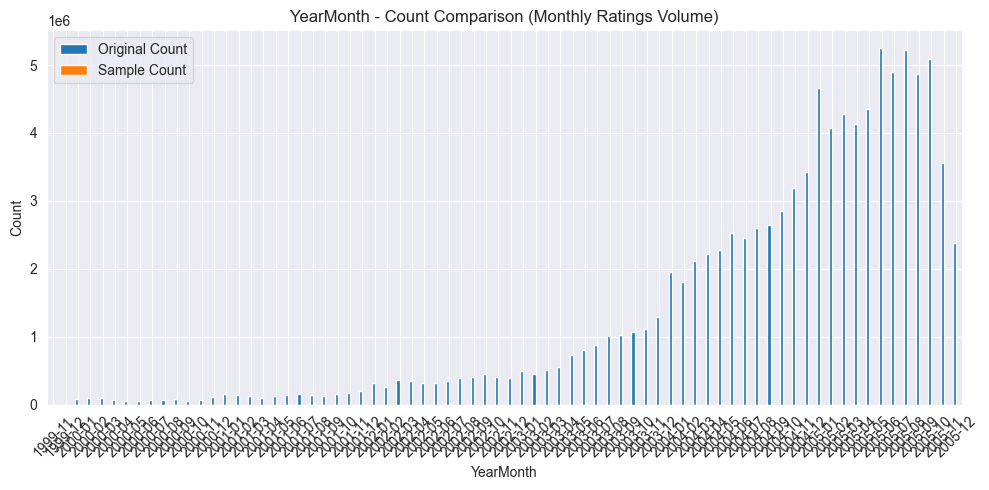

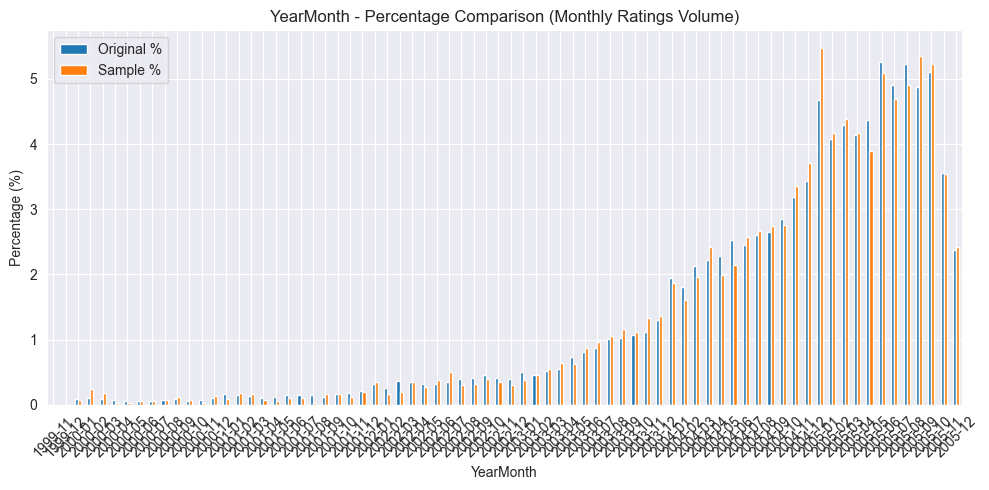

In [20]:
# Ensure 'Date' is datetime and create YearMonth
active_users_df['YearMonth'] = active_users_df['Date'].dt.to_period('M').astype(str)
final_sampled_df['YearMonth'] = final_sampled_df['Date'].dt.to_period('M').astype(str)

# Run comparisons
compare_distributions(active_users_df, final_sampled_df, 'Rating', title_suffix='(1 to 5)')
compare_distributions(active_users_df, final_sampled_df, 'movie_id', top_n=10, title_suffix='(Top 10 Movies)')
compare_distributions(active_users_df, final_sampled_df, 'YearMonth', title_suffix='(Monthly Ratings Volume)')


## Step 4: Line Plot – Monthly Ratings Over Time

/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_13228/3190385277.py:18: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) Arial.
  plt.tight_layout()
/Users/simon/PycharmProjects/rec-sys-project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


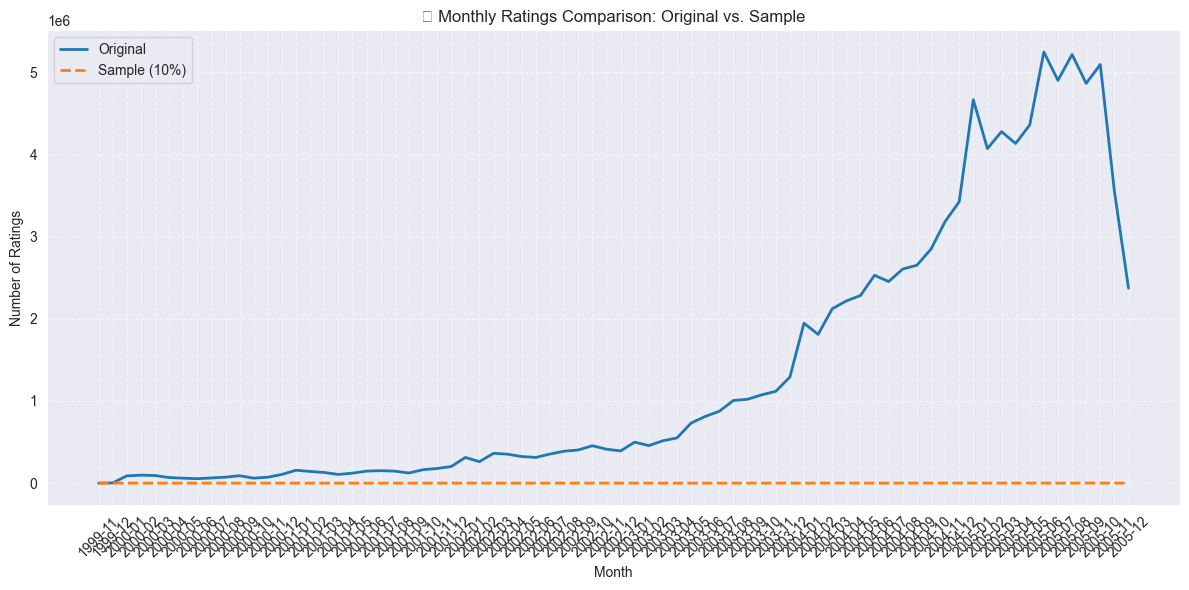

In [21]:
monthly_counts_full = active_users_df['YearMonth'].value_counts().sort_index()
monthly_counts_sample = final_sampled_df['YearMonth'].value_counts().sort_index()

df_monthly = pd.DataFrame({
    'Original': monthly_counts_full,
    'Sample': monthly_counts_sample
}).fillna(0)

plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly['Original'], label='Original', linewidth=2)
plt.plot(df_monthly.index, df_monthly['Sample'], label='Sample (10%)', linewidth=2, linestyle='--')
plt.title('📅 Monthly Ratings Comparison: Original vs. Sample')
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


## Step 5: Area Chart – Monthly Rating Composition by Score

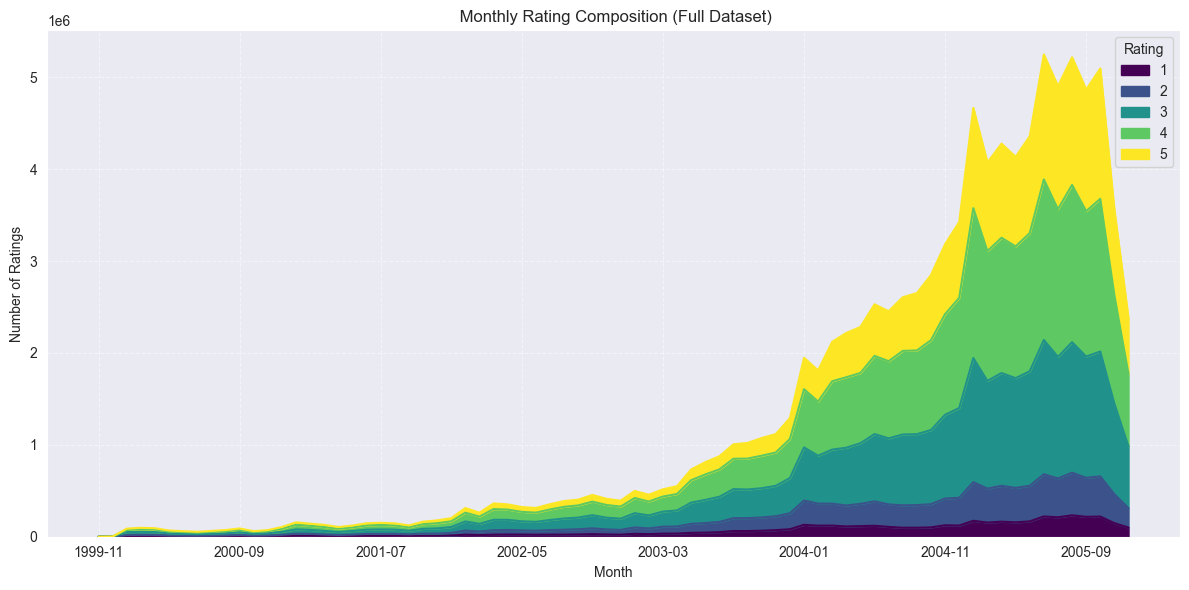

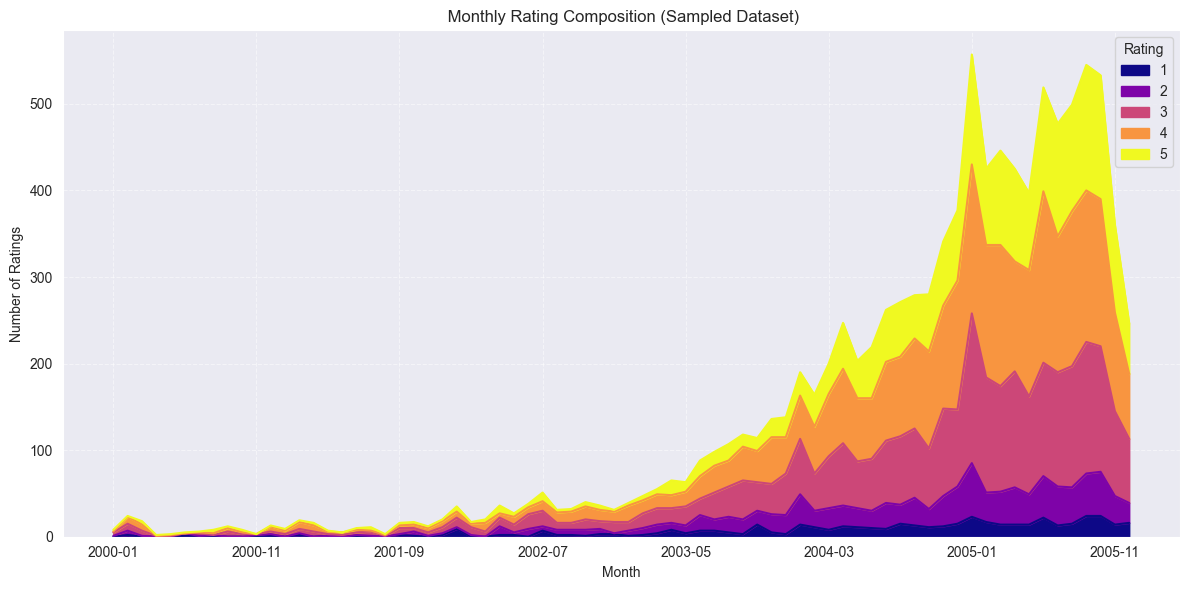

In [22]:
# Group by month and rating
monthly_rating_full = active_users_df.groupby([active_users_df['Date'].dt.to_period('M'), 'Rating']).size().unstack(fill_value=0)
monthly_rating_sample = final_sampled_df.groupby([final_sampled_df['Date'].dt.to_period('M'), 'Rating']).size().unstack(fill_value=0)

monthly_rating_full.index = monthly_rating_full.index.astype(str)
monthly_rating_sample.index = monthly_rating_sample.index.astype(str)

# Full dataset area chart
monthly_rating_full.plot.area(
    figsize=(12, 6),
    title=' Monthly Rating Composition (Full Dataset)',
    colormap='viridis'
)
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Sampled dataset area chart
monthly_rating_sample.plot.area(
    figsize=(12, 6),
    title=' Monthly Rating Composition (Sampled Dataset)',
    colormap='plasma'
)
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Step 6: Unique Value Comparison: Original vs Sampled Dataset

In [23]:
def compare_and_plot_uniques(original_df, sampled_df, columns):
    summary = []

    for col in columns:
        orig_unique = original_df[col].nunique()
        samp_unique = sampled_df[col].nunique()
        pct_diff = ((samp_unique - orig_unique) / orig_unique) * 100

        summary.append({
            'Column': col,
            'Original Unique': orig_unique,
            'Sampled Unique': samp_unique,
            'Difference': samp_unique - orig_unique,
            '% Difference': round(pct_diff, 2)
        })

    df_summary = pd.DataFrame(summary)

    return df_summary

columns_to_check = ['user_id', 'movie_id', 'Rating', 'Date', 'YearMonth']
compare_and_plot_uniques(active_users_df, final_sampled_df, columns_to_check)


,Column,Original Unique,Sampled Unique,Difference,% Difference
0,user_id,425608,2845,-422763,-99.33
1,movie_id,17770,3649,-14121,-79.47
2,Rating,5,5,0,0.00
3,Date,2182,1375,-807,-36.98
4,YearMonth,74,72,-2,-2.70


In [24]:
final_sampled_df.to_parquet("sampled_netflix.parquet", index=False)

In [25]:
final_sampled_df

,movie_id,user_id,Rating,Date,YearMonth
88,11748,1225150,1,2005-12-02,2005-12
184,16339,818050,1,2005-02-16,2005-02
239,17149,85701,1,2004-07-27,2004-07
255,2734,2213353,1,2004-09-29,2004-09
289,6174,1647667,1,2005-05-25,2005-05
...,...,...,...,...,...
997704,15689,2440061,5,2005-11-13,2005-11
997716,7553,1069538,5,2005-09-19,2005-09
997818,5732,1304932,5,2005-01-24,2005-01
997913,4352,2602500,5,2004-08-19,2004-08
